In [51]:
###### Import all necessary functions #######
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, silhouette_score
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import seaborn as sns

In [52]:
###### import the dataset #######
df = pd.read_csv('adult.csv', na_values = ['?', '??', '???'])
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [53]:
###### Check the missing value #######
if df.isnull().sum().sum() == 0:
    print("There is no NaN value in the dataset.")
else:
    print("There is NaN value in the dataset.")

There is NaN value in the dataset.


In [54]:
nan_columns_ = list(df.loc[:, df.isnull().sum() > 0].columns)
for column_ in nan_columns_:
    print(f'{column_:15} has NaN value = {df.loc[:, column_].isnull().sum()}')
    
###### print the shape of this dataset #######
print("The shape of this dataset is  = ", df.shape)

workclass       has NaN value = 2799
occupation      has NaN value = 2809
native-country  has NaN value = 857
The shape of this dataset is  =  (48842, 15)


In [55]:
###### This is kind of target guided ordinal encoding #######
df.loc[:, 'workclass'].nunique()

8

In [56]:
###### Label Encoding in Target class #######
df.loc[:, 'income'] = df.loc[:, 'income'].map({'<=50K': 0, '>50K': 1})
print("Done !")

Done !


In [57]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0


### Random Sample Imputation 

In [58]:
def random_sample_inputation(feature_):
    random_values_ = df.loc[:, feature_].dropna().sample(df.loc[:, feature_].isnull().sum().sum(), random_state = 42).values
    random_values_ = list(random_values_)
    nan_index_ = df.loc[df.loc[:, feature_].isnull(), feature_].index
    nan_index_ = list(nan_index_)
    ###### random sample imputation #######
    for _index, index_ in enumerate(nan_index_):
        df.loc[index_, feature_] = random_values_[_index]
        
    print(feature_, " random sample imputation is completed.")

In [59]:
for feature_ in ['workclass', 'occupation', 'native-country']:\
    random_sample_inputation(feature_)

workclass  random sample imputation is completed.
occupation  random sample imputation is completed.
native-country  random sample imputation is completed.


In [60]:
##### Check the missing value ######
if df.isnull().sum().sum() == 0:
    print("There is no NaN value present in this dataset.")
else:
    print("There is no NaN value present in this dataset.")

There is no NaN value present in this dataset.


In [61]:
df.head(3)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1


### Handle the Categorical features

In [62]:
###### workclass and education = Target Guided Ordinal Encoding #######
def target_guided_ordinal_encoding(feature_):
    target_guided_index_ = df.groupby([feature_])['income'].mean().sort_values(ascending = True).index
    df.loc[:, feature_] = df.loc[:, feature_].map({value_: index_ for index_, value_ in enumerate(target_guided_index_)})
    print(feature_, " is done.")

In [63]:
for feature_ in ['workclass', 'education']:
    target_guided_ordinal_encoding(feature_)

workclass  is done.
education  is done.


In [64]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,2,226802,2,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,2,89814,8,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,5,336951,11,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,2,160323,9,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,2,103497,9,10,Never-married,Protective-serv,Own-child,White,Female,0,0,30,United-States,0


In [65]:
##### Do the One Hot Encoding in marital-status,marital-status, relationship, race, gender ######
df = pd.get_dummies(df, columns = ['marital-status', 'occupation', 'relationship', 'race', 'gender'])
df.head()

,age,workclass,fnlwgt,education,educational-num,capital-gain,capital-loss,hours-per-week,native-country,income,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male
0,25,2,226802,2,7,0,0,40,United-States,0,...,1,0,0,0,0,1,0,0,0,1
1,38,2,89814,8,9,0,0,50,United-States,0,...,0,0,0,0,0,0,0,1,0,1
2,28,5,336951,11,12,0,0,40,United-States,1,...,0,0,0,0,0,0,0,1,0,1
3,44,2,160323,9,10,7688,0,40,United-States,1,...,0,0,0,0,0,1,0,0,0,1
4,18,2,103497,9,10,0,0,30,United-States,0,...,1,0,0,0,0,0,0,1,1,0


In [66]:
##### Mean Encoding in native-country ######
def mean_encoding(feature_):
    df.loc[:, feature_] = df.loc[:, feature_].map(df.groupby(feature_)['income'].mean().to_dict())
    print(feature_, " mean encoding is done.")

##### run a loop #####
for feature_ in ['native-country']:
    mean_encoding(feature_)

native-country  mean encoding is done.


In [67]:
df.head()

,age,workclass,fnlwgt,education,educational-num,capital-gain,capital-loss,hours-per-week,native-country,income,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male
0,25,2,226802,2,7,0,0,40,0.244351,0,...,1,0,0,0,0,1,0,0,0,1
1,38,2,89814,8,9,0,0,50,0.244351,0,...,0,0,0,0,0,0,0,1,0,1
2,28,5,336951,11,12,0,0,40,0.244351,1,...,0,0,0,0,0,0,0,1,0,1
3,44,2,160323,9,10,7688,0,40,0.244351,1,...,0,0,0,0,0,1,0,0,0,1
4,18,2,103497,9,10,0,0,30,0.244351,0,...,1,0,0,0,0,0,0,1,1,0


In [68]:
##### Save CSV file #####
df.to_csv('adult_new.csv')

In [69]:
###### Split the data into train and test ######
y = df.loc[:, 'income']
###### drop the income column #######
df.drop(columns = ['income'], inplace = True, axis = 1)

X = df.iloc[:, :].values

###### train and test split #######
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
####### print the shape ######
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36631, 43), (12211, 43), (36631,), (12211,))

In [70]:
###### Scaling the dataset with Standard Scaler #######
standard_scaler_ = StandardScaler()
X_train = standard_scaler_.fit_transform(X_train)
X_test  = standard_scaler_.transform(X_test)
####### print the shape ######
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36631, 43), (12211, 43), (36631,), (12211,))

In [71]:
###### Logistic Regression ########
def logistic(X_train, X_test, y_train, y_test):
    logistic_ = LogisticRegression()
    logistic_.fit(X_train, y_train)
    predicted_ = logistic_.predict(X_test)
    return accuracy_score(predicted_, y_test)

In [21]:
##### Decision Tree #######
def decision_tree(X_train, X_test, y_train, y_test):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    predicted_ = decision_tree.predict(X_test)
    return accuracy_score(predicted_, y_test)

In [22]:
###### Random Forest ######
def random_forest_(X_train, X_test, y_train, y_test):
    random_forest_ = RandomForestClassifier()
    random_forest_.fit(X_train, y_train)
    predicted_ = random_forest_.predict(X_test)
    return accuracy_score(predicted_, y_test)

In [23]:
###### Adaboost #######
def adaboost_(X_train, X_test, y_train, y_test):
    adaboost_ = AdaBoostClassifier()
    adaboost_.fit(X_train, y_train)
    predicted_ = adaboost_.predict(X_test)
    return accuracy_score(predicted_, y_test)

In [24]:
###### Gradient Descent #####
def gradient_boosting_(X_train, X_test, y_train, y_test):
    gradient_boosting_ = GradientBoostingClassifier()
    gradient_boosting_.fit(X_train, y_train)
    predicted_ = gradient_boosting_.predict(X_test)
    return accuracy_score(predicted_, y_test)

In [25]:
###### Xgboost ########
def xgboost_(X_train, X_test, y_train, y_test):
    xgboost_ = XGBClassifier()
    xgboost_.fit(X_train, y_train)
    predicted_ = xgboost_.predict(X_test)
    return accuracy_score(predicted_, y_test)

In [26]:
###### SVM #####
def svm_(X_train, X_test, y_train, y_test):
    svm_ = SVC()
    svm_.fit(X_train, y_train)
    predicted_ = svm_.predict(X_test)
    return accuracy_score(predicted_, y_test)

In [27]:
##### K Fold Cross validation ######
Kfold_ = KFold(n_splits = 5, shuffle = True, random_state = 42)
dict_  = {} 
models_ = ['logistic', 'svc', 'decision_tree', 'random_forest', 'adaboost', 'gradient_boost','xgboost']
call_Model_ = [logistic, svm_, decision_tree, random_forest_, adaboost_, gradient_boosting_, xgboost_]
for index_, model_ in enumerate(models_):
    accuracy_ = []
    count_ = 1
    print("Model # ", model_)
    for train_index_, test_index_ in Kfold_.split(X):
        ###### Train and Test Split ######
        print("Cross Validation # ", count_)
        X_train, X_test = X[train_index_], X[test_index_]
        y_train, y_test = y[train_index_], y[test_index_]
        accuracy_.append(call_Model_[index_](X_train, X_test, y_train, y_test))
        count_ = count_ + 1
    
    dict_[model_] = accuracy_
    print(model_, " is done.")    

Model #  logistic
Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
logistic  is done.
Model #  svc
Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
svc  is done.
Model #  decision_tree
Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
decision_tree  is done.
Model #  random_forest
Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
random_forest  is done.
Model #  adaboost
Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
adaboost  is done.
Model #  gradient_boost
Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
gradient_boost  is done.
Model #  xgboost
Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validat

In [28]:
for keys_, values_ in dict_.items():
    print(keys_, " accuracy is = ", np.array(values_).mean())

logistic  accuracy is =  0.7977558358943352
svc  accuracy is =  0.7982063303590584
decision_tree  accuracy is =  0.8148108949828676
random_forest  accuracy is =  0.8549607690307865
adaboost  accuracy is =  0.8611234923958847
gradient_boost  accuracy is =  0.8667539071469872
xgboost  accuracy is =  0.8732033227170908


In [29]:
### Grid Search CV for XgBOOST

##### parameters for XGBOOST #####
param_grid_ = {
    "learning_rate"     : [0.01, 0.1] ,
     "max_depth"        : [ 6, 10, 20],
     "min_child_weight" : [ 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7]}

##### fit into grid #####
grid_search_cv_ = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = param_grid_,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 3,
    verbose = 2)

##### call the grid #####
grid_search_cv_.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'gamma': [0.0, 0.1, 0.2, 0.3],
                         'learning_rate': [0.01, 0.1], 'max_depth': [6, 10, 20],
                         'min_child_weight': [3, 5, 7]},
             scoring='accuracy', verbose=2)

In [32]:
grid_search_cv_.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 3}

In [34]:
##### Train our model with this parameter ######
Kfold_ = KFold(n_splits = 10, shuffle = True, random_state = 42)
count_ = 1
accur_ = []
for train_index_, test_index_ in Kfold_.split(X):
    print("Cross Validation # ", count_)
    X_train, X_test = X[train_index_], X[test_index_]
    y_train, y_test = y[train_index_], y[test_index_]
    
    #### Train our model with those parameters ####
    xgboost_ = XGBClassifier(colsample_bytree = 0.5, gamma = 0.1, learning_rate = 0.1, max_depth = 6, min_child_weight = 3)
    xgboost_.fit(X_train, y_train)
    predicted_ = xgboost_.predict(X_test)
    accur_.append(accuracy_score(predicted_, y_test))
    count_ = count_ + 1

Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
Cross Validation #  6
Cross Validation #  7
Cross Validation #  8
Cross Validation #  9
Cross Validation #  10


In [35]:
np.array(accur_).mean()

0.8734283609002136

In [36]:
#### Grid Search CV for Gradient Boosting ######

parameters = {
    "n_estimators"  :[5, 50, 250, 500],
    "max_depth"     :[1, 3, 5, 7, 9],
    "learning_rate" :[0.01, 0.1, 1, 10, 100]
}

grid_search_cv_ = GridSearchCV(estimator = GradientBoostingClassifier(),
                              param_grid = parameters,
                              scoring = 'accuracy',
                              n_jobs = -1,
                              cv = 3,
                              verbose = 2
)
grid_search_cv_.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]},
             scoring='accuracy', verbose=2)

In [38]:
grid_search_cv_.best_score_, grid_search_cv_.best_params_

(0.8744711625009175,
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500})

In [39]:
Kfold_ = KFold(n_splits = 10, shuffle = True, random_state = 42)
count_ = 1
accur_ = []
precision_ = []
reacll_ = []
f1_score_ = []

###### run KfOLD #######
for train_index_, test_index_ in Kfold_.split(X):
    print("Cross Validation # ", count_)
    X_train, X_test = X[train_index_], X[test_index_]
    y_train, y_test = y[train_index_], y[test_index_]
    
    #####Call the Gradient Boosting ######
    gradient_boosting_ = GradientBoostingClassifier(learning_rate = 0.1,
                                                    max_depth = 3,
                                                    n_estimators = 500)
    gradient_boosting_.fit(X_train, y_train)
    predicted_ = gradient_boosting_.predict(X_test)
    accur_.append(accuracy_score(predicted_, y_test))
    precision_.append(precision_score(predicted_, y_test))
    reacll_.append(recall_score(predicted_, y_test))
    f1_score_.append(f1_score(predicted_, y_test))
    count_ = count_ + 1

Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
Cross Validation #  6
Cross Validation #  7
Cross Validation #  8
Cross Validation #  9
Cross Validation #  10


In [40]:
####### This is initial output without using Imbalanced Dataset function ########
print("accuracy is  = ", np.array(accur_).mean())
print("recall is    = ", np.array(reacll_).mean())
print("precision is = ", np.array(precision_).mean())
print("f1 score is  = ", np.array(f1_score_).mean())

accuracy is  =  0.8742883117601643
recall is    =  0.7866175302027545
precision is =  0.6510917241691802
f1 score is  =  0.7123760112595502


In [42]:
y.value_counts()

0    37155
1    11687
Name: income, dtype: int64

In [54]:
##### Voting Ensemble ######

#### To solve this, we will use Gradient Boosting, XgBoost, Adaboost ####

from sklearn.ensemble import VotingClassifier

voting_classifier_ = VotingClassifier(estimators = [
    ('gradient_boosting_', GradientBoostingClassifier(learning_rate = 0.1,
                                                      max_depth = 3,
                                                      n_estimators = 500)),
    ('XgBoost', XGBClassifier(colsample_bytree = 0.5, 
                              gamma = 0.1, 
                              learning_rate = 0.1, 
                              max_depth = 6, 
                              min_child_weight = 3)),
    ('Adaboost', AdaBoostClassifier(n_estimators = 500,
                                   learning_rate = 0.1))
], voting = 'soft')

voting_classifier_.fit(X_train, y_train)

VotingClassifier(estimators=[('gradient_boosting_',
                              GradientBoostingClassifier(n_estimators=500)),
                             ('XgBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0.1,
                                            gpu_id=None, grow_policy=None,
                                            importance...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...)),
                             ('Adaboost',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=500))],
                 voting='soft')

In [55]:
predicted_ = voting_classifier_.predict(X_test)
accuracy_score(predicted_, y_test)

0.8697788697788698

In [22]:
###### Check that whether it's imbalanced or not ######
y.value_counts()
###### Imbalanced dataset #######

0    37155
1    11687
Name: income, dtype: int64

In [23]:
##### Handle Imbalanced Dataset #####

In [24]:
###### Import the ADASYN #######
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE, SVMSMOTE
###### scaling the dataset ######
scaler_ = StandardScaler()
###### Fit X #######
X = scaler_.fit_transform(X)
###### y #######
y = y
X.shape, y.shape

((48842, 43), (48842,))

In [25]:
###### fit the dataset into ADASYN ######
def ADASYN_(X, y):
    adasyn_ = ADASYN(random_state = 42, n_jobs = -1)
    X, y = adasyn_.fit_resample(X, y)
    return X, y

###### BorderlineSMOTE #########
def BorderlineSMOTE_(X, y):
    border_line_smote_ = BorderlineSMOTE()
    X, y = border_line_smote_.fit_resample(X, y)
    return X, y

####### SVMSMOTE #########
def SVMSMOTE_(X, y):
    svm_smote_ = SVMSMOTE()
    X, y = svm_smote_.fit_resample(X, y)
    return X,y

In [26]:
###### Call the BorderLineSmote #######
X, y= ADASYN_(X, y)
X.shape, y.shape

((74445, 43), (74445,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
xgboost_ = XGBClassifier()
xgboost_.fit(X_train, y_train)
predicted_ = xgboost_.predict(X_test)
accuracy_score(predicted_, y_test)

0.9080773708247515

In [28]:
recall_score(predicted_, y_test)

0.9083043439479083

In [29]:
precision_score(predicted_, y_test)

0.908547466095646

In [30]:
f1_score(predicted_, y_test)

0.9084258887550738

In [337]:
Kfold_ = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
count_, accuracy_, recall_, precision_, f1_score_ = 1, [], [], [], []

##### run a loop for StratifiedKFold #####
for train_index_, test_index_ in Kfold_.split(X, y):
    print("Cross Validation # ", count_)
    X_train, X_test = X[train_index_], X[test_index_]
    y_train, y_test = y[train_index_], y[test_index_]
    
    ###### Fit the model #######
    xgboost_ = XGBClassifier()
    xgboost_.fit(X_train, y_train)
    predicted_ = xgboost_.predict(X_test)
    accuracy_.append(accuracy_score(predicted_, y_test))
    recall_.append(recall_score(predicted_, y_test))
    precision_.append(precision_score(predicted_, y_test))
    f1_score_.append(f1_score(predicted_, y_test))
    count_ = count_ + 1

Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
Cross Validation #  6
Cross Validation #  7
Cross Validation #  8
Cross Validation #  9
Cross Validation #  10


In [338]:
print("accuracy is  = ", np.array(accuracy_).mean())
print("recall is    = ", np.array(recall_).mean())
print("precision is = ", np.array(precision_).mean())
print("f1 score is  = ", np.array(f1_score_).mean())

accuracy is  =  0.9064141100652501
recall is    =  0.9033965823444585
precision is =  0.9105926521855727
f1 score is  =  0.9069539467327303


In [260]:
###### Tuning the XgBOOST ######

##### parameters for XGBOOST #####
param_grid_ = {
    "learning_rate"     : [0.01, 0.1],
     "max_depth"        : [6, 10, 20, None],
     "min_child_weight" : [3, 5, 7, None ],
     "gamma"            : [0.1, 0.2 , 0.3],
     "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]}

##### fit into grid #####
grid_search_cv_ = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = param_grid_,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 3,
    verbose = 2)

##### call the grid #####
grid_search_cv_.fit(X_train, y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'gamma': [0.1, 0.2, 0.3], 'learning_rate': [0.01, 0.1],
                         'max_depth': [6, 10, 20, None],
                         'min_child_weight': [3, 5, 7, None]},
             scoring='accuracy', verbose=2)

In [264]:
grid_search_cv_.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.1,
 'learning_rate': 0.01,
 'max_depth': 20,
 'min_child_weight': None}

In [339]:
Kfold_ = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
count_, accuracy_, recall_, precision_, f1_score_ = 1, [], [], [], []

##### run a loop for StratifiedKFold #####
for train_index_, test_index_ in Kfold_.split(X, y):
    print("Cross Validation # ", count_)
    X_train, X_test = X[train_index_], X[test_index_]
    y_train, y_test = y[train_index_], y[test_index_]
    
    ###### Fit the model #######
    xgboost_ = XGBClassifier()
    xgboost_.fit(X_train, y_train)
    predicted_ = xgboost_.predict(X_test)
    accuracy_.append(accuracy_score(predicted_, y_test))
    recall_.append(recall_score(predicted_, y_test))
    precision_.append(precision_score(predicted_, y_test))
    f1_score_.append(f1_score(predicted_, y_test))
    count_ = count_ + 1

Cross Validation #  1
Cross Validation #  2
Cross Validation #  3
Cross Validation #  4
Cross Validation #  5
Cross Validation #  6
Cross Validation #  7
Cross Validation #  8
Cross Validation #  9
Cross Validation #  10


In [340]:
print("accuracy is  = ", np.array(accuracy_).mean())
print("recall is    = ", np.array(recall_).mean())
print("precision is = ", np.array(precision_).mean())
print("f1 score is  = ", np.array(f1_score_).mean())

accuracy is  =  0.9064141100652501
recall is    =  0.9033965823444585
precision is =  0.9105926521855727
f1 score is  =  0.9069539467327303


In [341]:
adaboost_ = AdaBoostClassifier()
adaboost_.fit(X_train, y_train)
predicted_ = adaboost_.predict(X_test)

In [342]:
print("accuracy is  = ", accuracy_score(predicted_, y_test))

accuracy is  =  0.8269747447608813


In [31]:
##### Stacking and Blending #####

estimators_ = [
    ('Decision_tree', DecisionTreeClassifier(random_state = 42, criterion = 'entropy')),
    ('XgBoost', XGBClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors = 3)),
]

stacking_blending_ = StackingClassifier(estimators = estimators_, final_estimator = XGBClassifier(), cv = 10)
stacking_blending_.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('Decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42)),
                               ('XgBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_po...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None,
                                                 reg_alpha=None,
                                                 reg_lambda=None, ...))

In [32]:
predicted_ = stacking_blending_.predict(X_test)
print("accuracy is  = ", accuracy_score(predicted_, y_test))
print("recall is  = ", recall_score(predicted_, y_test))
print("precision is  = ", precision_score(predicted_, y_test))
print("f1 score is  = ", f1_score(predicted_, y_test))

accuracy is  =  0.9130025969374048
recall is  =  0.9126948775055679
precision is  =  0.9140792291220556
f1 score is  =  0.913386528774573


In [37]:
###### Voting Ensemble Technique #######
voting_classifier_ = VotingClassifier(estimators = estimators_, n_jobs = -1, voting = 'soft')
voting_classifier_.fit(X_train, y_train)

VotingClassifier(estimators=[('Decision_tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=42)),
                             ('XgBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=Non...
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...)),
                             ('KNN', KNeighborsClassifier(n_neighbors=3))],
                 n_jobs=-1, voting='soft')

In [38]:
predicted_ = voting_classifier_.predict(X_test)
print("accuracy is  = ", accuracy_score(predicted_, y_test))
print("recall is  = ", recall_score(predicted_, y_test))
print("precision is  = ", precision_score(predicted_, y_test))
print("f1 score is  = ", f1_score(predicted_, y_test))

accuracy is  =  0.8980925942509179
recall is  =  0.8817094017094017
precision is  =  0.9204139900071378
f1 score is  =  0.9006460625109132


<AxesSubplot:>

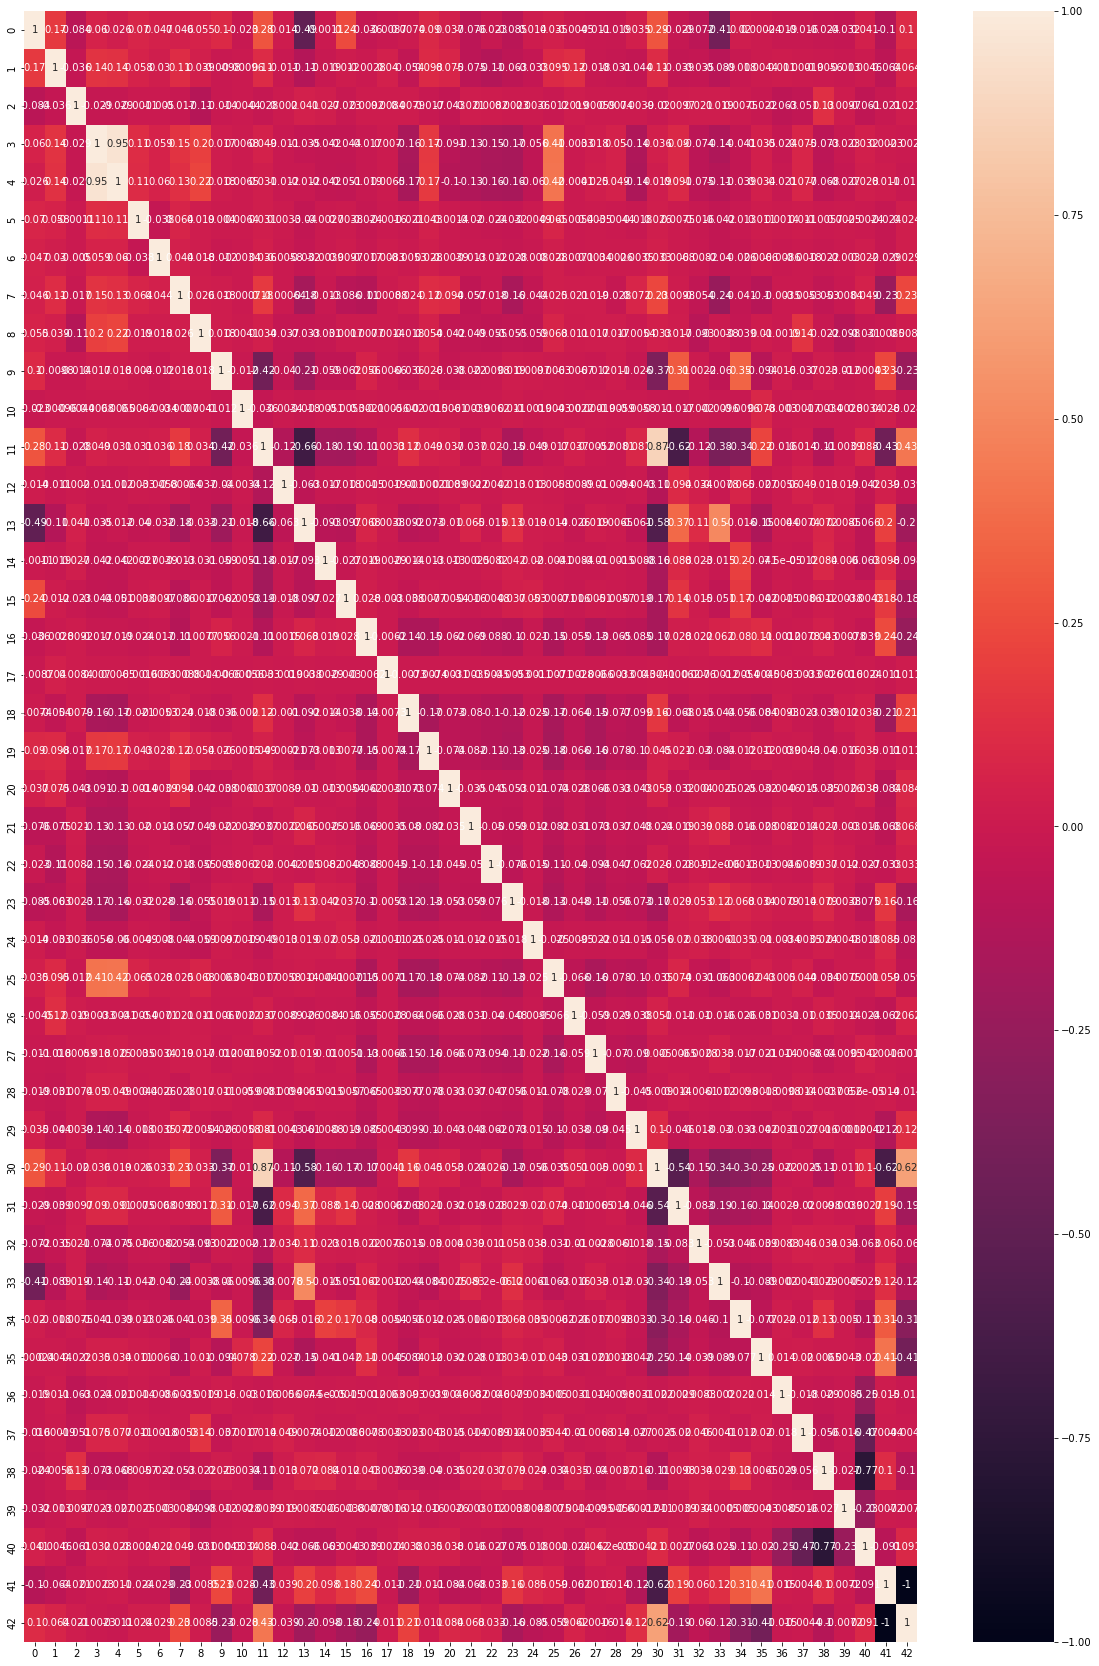

In [352]:
##### Feature Importance - Using Pearson Correlation Technique ######

##### draw the heatmap #####
plt.figure(figsize = (20, 30))
corr_ = pd.DataFrame(X).corr()
sns.heatmap(corr_, annot = True)

In [40]:
##### Remove Feature from the dataset ######
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [41]:
###### Feature Importance from Decision Tree ######
feature_imporatnce = pd.DataFrame(decision_tree.feature_importances_, columns = ['feature_importance'])
best_features_ = feature_imporatnce[feature_imporatnce.loc[:, 'feature_importance'] >= 0.005].index
X = pd.DataFrame(X)
###### X and y ######
X = X.loc[:, best_features_]
y = y
X.shape, y.shape

((74445, 17), (74445,))

In [42]:
###### Split the dataset into train and test ########
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [47]:
##### Stacking and Blending #####

estimators_ = [
    ('Decision_tree', DecisionTreeClassifier(criterion = 'entropy',
                                            max_depth = 20,
                                            min_samples_leaf = 50)),
    ('XgBoost', XGBClassifier(colsample_bytree = 0.3,
                              gamma = 0.5,
                              learning_rate = 0.1,
                              max_depth = 20)),
    ('Random_forest', RandomForestClassifier(random_state = 42, max_samples = 0.55, bootstrap = True)),
]

stacking_blending_ = StackingClassifier(estimators = estimators_, final_estimator = XGBClassifier(), cv = 10)
stacking_blending_.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('Decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=20,
                                                       min_samples_leaf=50)),
                               ('XgBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.3,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=0.5,
                                              gpu_...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None,
                                                 reg_alpha=None,
                                                 reg_lambda=None, ...))

In [48]:
predicted_ = stacking_blending_.predict(X_test)
print("accuracy is  = ", accuracy_score(predicted_, y_test))
print("recall is  = ", recall_score(predicted_, y_test))
print("precision is  = ", precision_score(predicted_, y_test))
print("f1 score is  = ", f1_score(predicted_, y_test))

accuracy is  =  0.9081669203904361
recall is  =  0.9264226506472945
precision is  =  0.8874910778015703
f1 score is  =  0.9065390749601276


In [49]:
###### Voting Ensemble Technique #######
voting_classifier_ = VotingClassifier(estimators = estimators_, n_jobs = -1, voting = 'hard')
voting_classifier_.fit(X_train, y_train)

VotingClassifier(estimators=[('Decision_tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=20,
                                                     min_samples_leaf=50)),
                             ('XgBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0.5,
                                            gpu_id=None,...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=20,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...)),
                             ('Random_forest',
                              RandomForestClassifier(max_samples=0.55,
                                                     random_state=42))],
                 n_jobs=-1)

In [50]:
predicted_ = voting_classifier_.predict(X_test)
print("accuracy is  = ", accuracy_score(predicted_, y_test))
print("recall is  = ", recall_score(predicted_, y_test))
print("precision is  = ", precision_score(predicted_, y_test))
print("f1 score is  = ", f1_score(predicted_, y_test))

accuracy is  =  0.8934807916181606
recall is  =  0.8889770023790642
precision is  =  0.9001605995717344
f1 score is  =  0.8945338475861151


In [437]:
adaboost_ = KNeighborsClassifier(n_neighbors=7)
adaboost_.fit(X_train, y_train)
predicted_ = adaboost_.predict(X_test)
accuracy_score(predicted_, y_test)

0.8294080773708248

In [438]:
adaboost_ = RandomForestClassifier(n_estimators = 300, random_state = 42, max_samples = 0.5)
adaboost_.fit(X_train, y_train)
predicted_ = adaboost_.predict(X_test)
accuracy_score(predicted_, y_test)

0.8849288080952807

In [439]:
###### Tuning the XgBOOST ######

##### parameters for XGBOOST #####
param_grid_ = {
    "learning_rate"     : [0.01, 0.1, 1.0],
     "max_depth"        : [6, 10, 15, 20, 30, None],
     "min_child_weight" : [3, 5, 7, None],
     "gamma"            : [0.1, 0.2 , 0.3, 0.4, 0.5],
     "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]}

##### fit into grid #####
grid_search_cv_ = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = param_grid_,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 3,
    verbose = 2)

##### call the grid #####
grid_search_cv_.fit(X_train, y_train)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'learning_rate': [0.01, 0.1, 1.0],
                         'max_depth': [6, 10, 15, 20, 30, None],
                         'min_child_weight': [3, 5, 7, None]},
             scoring='accuracy', verbose=2)

In [440]:
grid_search_cv_.best_score_

0.9057397247805715

In [441]:
grid_search_cv_.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_weight': None}

In [25]:
##### HyperParameter for Decision Tree #######
param_grid_ = {
    'max_depth'       : [2, 3, 5, 10, 20, 30, 50, None],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion'       : ["gini", "entropy"],
    'max_features'    : ['auto', 'sqrt', 'log2', None]
}
###### Input those ######
grid_search_cv_ = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = param_grid_, cv = 3, n_jobs = -1)
grid_search_cv_.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20, 30, 50, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [5, 10, 20, 50, 100]})

In [27]:
grid_search_cv_.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 50}

In [28]:
grid_search_cv_.best_score_

0.85487711488858

In [36]:
##### Stacking and Blending #####

estimators_ = [
    ('Decision_tree', DecisionTreeClassifier()),
    ('XgBoost', XGBClassifier()),
    ('Random_forest', RandomForestClassifier(random_state = 42, max_samples = 0.55, bootstrap = True)),
]

stacking_blending_ = StackingClassifier(estimators = estimators_, final_estimator = XGBClassifier(), cv = 10)
stacking_blending_.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('Decision_tree', DecisionTreeClassifier()),
                               ('XgBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              inte...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None,
                                                 reg_alpha=None,
                                                 reg_lambda=None, ...))

In [37]:
predicted_ = stacking_blending_.predict(X_test)
print("accuracy is  = ", accuracy_score(predicted_, y_test))
print("recall is  = ", recall_score(predicted_, y_test))
print("precision is  = ", precision_score(predicted_, y_test))
print("f1 score is  = ", f1_score(predicted_, y_test))

accuracy is  =  0.8756039636393416
recall is  =  0.7775933609958506
precision is  =  0.655932796639832
f1 score is  =  0.7116005316119233


In [93]:
##### PCA ######

pca_ = PCA(n_components = 35)
X = pca_.fit_transform(X)

In [32]:
X.shape

(74445, 43)

In [95]:
np.cumsum(pca_.explained_variance_ratio_)

array([0.10214589, 0.16722816, 0.21759515, 0.26189744, 0.30352723,
       0.33590611, 0.36780664, 0.39872694, 0.42810224, 0.45701729,
       0.48533059, 0.51309301, 0.53973241, 0.56622849, 0.59202699,
       0.61771998, 0.64261437, 0.66739769, 0.69187319, 0.71571479,
       0.73909494, 0.76144348, 0.78314325, 0.80389731, 0.82417233,
       0.84420735, 0.86388995, 0.88266471, 0.90012556, 0.91723553,
       0.93416243, 0.94991253, 0.96452165, 0.97672909, 0.9885997 ])

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [97]:
xgboost_ = XGBClassifier()
xgboost_.fit(X_train, y_train)
predicted_ = xgboost_.predict(X_test)

In [98]:
print("accuracy is  = ", accuracy_score(predicted_, y_test))
print("recall is  = ", recall_score(predicted_, y_test))
print("precision is  = ", precision_score(predicted_, y_test))
print("f1 score is  = ", f1_score(predicted_, y_test))

accuracy is  =  0.835945195665801
recall is  =  0.8002706575386085
precision is  =  0.896948608137045
f1 score is  =  0.8458561211611275


In [34]:
X_train.shape, y_train.shape

((52111, 29), (52111,))

## So, Our Model will be

In [100]:
df = pd.read_csv('adult_new.csv')
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,educational-num,capital-gain,capital-loss,hours-per-week,native-country,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male
0,0,25,2,226802,2,7,0,0,40,0.244351,...,1,0,0,0,0,1,0,0,0,1
1,1,38,2,89814,8,9,0,0,50,0.244351,...,0,0,0,0,0,0,0,1,0,1
2,2,28,5,336951,11,12,0,0,40,0.244351,...,0,0,0,0,0,0,0,1,0,1
3,3,44,2,160323,9,10,7688,0,40,0.244351,...,0,0,0,0,0,1,0,0,0,1
4,4,18,2,103497,9,10,0,0,30,0.244351,...,1,0,0,0,0,0,0,1,1,0


In [101]:
##### split the dataset into X and Y ######
y = df.loc[:, 'income']
##### delete this income column ######
df.drop(['income'], axis = 1, inplace = True)
X = df.iloc[:].values

In [102]:
###### print the shape of this data #######
print("The shape of this data is: ", df.shape)

The shape of this data is:  (48842, 44)


In [103]:
###### Scaling the dataset using Standard Sclaer ######
scaler_ = StandardScaler()
X = scaler_.fit_transform(X)
X.shape

(48842, 44)

In [104]:
##### It's an imbalanced dataset ######
y.value_counts()

0    37155
1    11687
Name: income, dtype: int64

In [105]:
###### To Solve this we are using ADASYN ######
X, y = ADASYN_(X, y)
###### print the shape of this dataset #######
X.shape, y.shape

((74830, 44), (74830,))

In [106]:
###### Split the dataset ######
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [107]:
##### Now using Stacking and Blending for prediction ######

##### Stacking and Blending #####

estimators_ = [
    ('Decision_tree', DecisionTreeClassifier(random_state = 42, criterion = 'entropy')),
    ('XgBoost', XGBClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors = 3)),
    ('Random_forest', RandomForestClassifier())
]

stacking_blending_ = StackingClassifier(estimators = estimators_, final_estimator = XGBClassifier(), cv = 10)
stacking_blending_.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('Decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42)),
                               ('XgBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_po...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None,
                                                 reg_alpha=None,
                                                 reg_lambda=None, ...))

In [108]:
predicted_ = stacking_blending_.predict(X_test)
print("accuracy is   = ", accuracy_score(predicted_, y_test))
print("recall is     = ", recall_score(predicted_, y_test))
print("precision is  = ", precision_score(predicted_, y_test))
print("f1 score is   = ", f1_score(predicted_, y_test))

accuracy is  =  0.9202637088511738
recall is  =  0.9224413646055437
precision is  =  0.9188495575221239
f1 score is  =  0.9206419577939351


In [ ]:
###### GridSearchCV for Random Forest #######
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
param_grid_ = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_search_cv_ = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid_, n_jobs = -1, cv = 3)
grid_search_cv_.fit(X_train, y_train)